# Notebook Follow UP

Este Notebook es para poder explorar los datos ver formatos y tener una documentacion funcional de como va ser la logica de calculo de cada uno de las metricas

In [32]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"


In [3]:
trips = pd.read_excel(DATA_DIR / "bus_data.xlsx")
coor = pd.read_excel(DATA_DIR / "coordenadas_1.xlsx", header=1)
org = pd.read_excel(DATA_DIR / "origen-destino.xlsx", header=1)


In [4]:
# 1 Ordenamos los Data Sets
org = org.iloc[:, 1:] 
coor = coor.iloc[:, 1:] 
coor=coor.rename(columns={'Unnamed: 1':'terminal_name'})
coor['terminal_name'] = coor['terminal_name'].str.replace('Viña', 'Viña del mar')
coor=coor.rename(columns={'Lat1':'lat1'})

In [5]:
org['Origen']=org['Origen'].str.lower()
org['Destino']=org['Destino'].str.lower()

In [6]:
trips.describe()

,Stop_Start,Stop_Duration,Lat,Long
count,36313,36313.000000,36313.000000,36313.000000
mean,2024-08-20 21:29:59.449343232,525.334674,-27.107370,-58.061339
min,2024-06-04 17:07:38,3.000000,-33.570888,-71.643052
25%,2024-07-17 22:33:18,23.000000,-33.452298,-71.528773
50%,2024-08-08 03:19:59,58.000000,-33.142245,-70.894038
75%,2024-09-24 02:44:53,225.000000,-33.025442,-70.680877
max,2024-11-18 16:06:36,65156.000000,0.000000,0.000000
std,NaN,2045.948596,12.875445,27.566791


Podemos ver que existen porblemas en los datos de trips donde se tene latitudes y longitudes como 0.0 , ademas debemos poder tener los mismos nombres para todas las tablas ya que haremos joins y operaciones basadas en ellas.

## Trips

In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36313 entries, 0 to 36312
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   VehicleID      36313 non-null  object        
 1   Stop_Start     36313 non-null  datetime64[ns]
 2   Stop_Duration  36313 non-null  int64         
 3   Lat            36313 non-null  float64       
 4   Long           36313 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
trips.query(" Lat==0 or Long ==0")

,VehicleID,Stop_Start,Stop_Duration,Lat,Long
1341,bus_1,2024-09-25 13:15:05,100,0.0,0.0
1505,bus_1,2024-10-03 18:01:13,100,0.0,0.0
1534,bus_1,2024-10-05 08:31:13,100,0.0,0.0
1986,bus_1,2024-10-26 18:00:47,100,0.0,0.0
1987,bus_1,2024-10-26 18:01:58,20,0.0,0.0
...,...,...,...,...,...
33674,bus_5,2024-07-22 13:38:16,100,0.0,0.0
33676,bus_5,2024-07-22 15:24:45,100,0.0,0.0
33701,bus_5,2024-07-24 09:25:00,100,0.0,0.0
33795,bus_5,2024-08-13 18:47:58,100,0.0,0.0


Existen 6679 registros con porblemas de deteccion de la latitud y longitud.

Primero reorganicemos este dataset.

In [9]:
trips=trips.rename(columns={'Lat':'lat','Long':'long'})

In [10]:
# definimos la regla para poder asociar la localizacion de un bus a un lugar o sector en particular dado el dataset de coordenadas.

def match_terminal(lat, long, bounds_df, delta=0.1):
    for _, row in bounds_df.iterrows():
        lat_min = min(row['lat1'], row['lat2']) - delta
        lat_max = max(row['lat1'], row['lat2']) + delta
        lon_min = min(row['long1'], row['long2']) - delta
        lon_max = max(row['long1'], row['long2']) + delta

        if lat_min <= lat <= lat_max and lon_min <= long <= lon_max:
            return row['terminal_name']
    return None


#-Matcheamos  esas latitutdes y longituds dado un delta , ya que puede igual o no. 

trips['terminal_name'] = trips.apply(lambda x: match_terminal(x['lat'], x['long'], coor), axis=1)


In [11]:

# Ademas eliminamos los que no se asocian a ninguno
trips.terminal_name.value_counts( dropna = False,normalize=True)


terminal_name
None            0.343128
Viña del mar    0.277945
San Borja       0.272327
Curacavi        0.059813
Placilla        0.024729
Pajaritos       0.010299
Coquimbo        0.005921
Libertadores    0.005838
Name: proportion, dtype: float64

None Corresponde al 34,3 % de los datos los cuales no seran utilizados en el analisis

In [12]:
# Los Eliminamos ya que no nos sirven.
trips=trips.dropna(subset={'terminal_name'})


In [13]:
# Dentro de esta parte del codigo tenemos de como creamos los ids de los viajes o cual es la logica de creacion de un viaje .

# 1: ordenar por vehículo y tiempo
df= trips.sort_values(['VehicleID', 'Stop_Start']).reset_index(drop=True)

# 2: lista de rutas válidas normalizadas
# se debe cabiar por algo dinamico dado el excel

rutas_validas = list(zip(org['Origen'],org['Destino']))

# 3: normalizar terminal
df['terminal_name'] = df['terminal_name'].str.lower().fillna('')

# 4: lógica para asignar trip_id
trip_id = 0
en_viaje = False
origen = ''
trip_ids = []

for i, row in df.iterrows():
    terminal = row['terminal_name']
    
    if not en_viaje and terminal in [r[0] for r in rutas_validas]:
        # Revisar Posible inicio de viaje ! → asigna un nuevo id
        origen = terminal
        en_viaje = True
        trip_id += 1
        trip_ids.append(trip_id)

    elif en_viaje and (origen, terminal) in rutas_validas:
        # Llegó a un destino válido → cerrar viaje
        trip_ids.append(trip_id)
        en_viaje = False
        origen = ''

    elif en_viaje:
        # Sigue en viaje, sin llegar a destino → no cierra viaje
        trip_ids.append(trip_id)
    else:
        # No está en viaje ni en terminal válido → cierra 
        trip_ids.append(None)

# Finalmente asignamos al dataframe
df['trip_id'] = trip_ids


In [14]:
df

,VehicleID,Stop_Start,Stop_Duration,lat,long,terminal_name,trip_id
0,BUS-KDVX32,2024-06-27 13:05:39,12,-33.442783,-70.694558,san borja,1.0
1,BUS-KDVX32,2024-06-27 18:56:24,6,-33.442792,-70.694638,san borja,1.0
2,BUS-KDVX32,2024-06-28 10:21:51,242,-33.442982,-70.694260,san borja,1.0
3,BUS-KDVX32,2024-08-21 12:51:52,11,-33.443005,-70.694617,san borja,1.0
4,BUS-KDVX32,2024-08-21 14:34:10,11,-33.443173,-70.694588,san borja,1.0
...,...,...,...,...,...,...,...
23848,bus_5,2024-11-18 13:22:09,155,-33.113792,-71.560542,viña del mar,2081.0
23849,bus_5,2024-11-18 13:58:19,26,-33.411697,-71.161455,curacavi,2081.0
23850,bus_5,2024-11-18 14:34:18,433,-33.457115,-70.716720,san borja,2081.0
23851,bus_5,2024-11-18 14:55:46,145,-33.455102,-70.680337,san borja,2082.0


In [15]:
df.query("VehicleID == 'bus_1' & Stop_Start >='2024-08-16' & Stop_Start <'2024-08-18'")

,VehicleID,Stop_Start,Stop_Duration,lat,long,terminal_name,trip_id
802,bus_1,2024-08-16 07:16:03,1706,-33.025422,-71.546983,viña del mar,167.0
803,bus_1,2024-08-16 09:05:39,142,-33.457095,-70.716500,san borja,167.0
804,bus_1,2024-08-16 09:22:14,111,-33.455102,-70.680352,san borja,168.0
805,bus_1,2024-08-16 10:12:45,449,-33.454402,-70.680063,san borja,168.0
806,bus_1,2024-08-16 10:32:24,1137,-33.457763,-70.715840,san borja,168.0
807,bus_1,2024-08-16 12:21:41,714,-33.025473,-71.546618,viña del mar,168.0
808,bus_1,2024-08-17 11:59:55,214,-33.455212,-70.683003,san borja,169.0
809,bus_1,2024-08-17 12:11:49,417,-33.454377,-70.680123,san borja,169.0
810,bus_1,2024-08-17 12:32:43,1453,-33.457673,-70.715793,san borja,169.0
811,bus_1,2024-08-17 14:24:16,1031,-33.025418,-71.546512,viña del mar,169.0


In [16]:
trip_summary = df.dropna(subset=['trip_id']).groupby('trip_id').agg(
    VehicleID=('VehicleID', 'first'),
    origen=('terminal_name', 'first'),
    destino=('terminal_name', 'last'),
    inicio=('Stop_Start', 'first'),
    fin=('Stop_Start', 'last'),
    duracion_minutos=('Stop_Start', lambda x: (x.max() - x.min()).total_seconds() / 60),
    num_paradas=('Stop_Start', 'count'),
    stop_duration_total_minutos=('Stop_Duration', lambda x: x.sum() / 60)

).reset_index()


In [17]:
trip_summary

,trip_id,VehicleID,origen,destino,inicio,fin,duracion_minutos,num_paradas,stop_duration_total_minutos
0,1.0,BUS-KDVX32,san borja,viña del mar,2024-06-27 13:05:39,2024-10-05 07:25:53,143660.233333,33,253.100000
1,2.0,BUS-KDVX32,viña del mar,pajaritos,2024-10-05 07:43:15,2024-10-05 09:24:31,101.266667,11,45.300000
2,3.0,BUS-KDVX32,pajaritos,viña del mar,2024-10-05 09:25:03,2024-10-05 13:19:17,234.233333,19,183.483333
3,4.0,BUS-KDVX32,san borja,viña del mar,2024-10-05 13:40:58,2024-10-05 16:22:28,161.500000,9,499.416667
4,5.0,BUS-KDVX32,viña del mar,san borja,2024-10-05 17:38:08,2024-10-05 18:40:39,62.516667,4,306.633333
...,...,...,...,...,...,...,...,...,...
2077,2078.0,bus_5,san borja,viña del mar,2024-11-17 21:49:05,2024-11-18 00:05:39,136.566667,5,10.283333
2078,2079.0,bus_5,viña del mar,san borja,2024-11-18 07:04:29,2024-11-18 09:22:46,138.283333,2,12.983333
2079,2080.0,bus_5,san borja,viña del mar,2024-11-18 09:42:28,2024-11-18 11:32:21,109.883333,3,23.816667
2080,2081.0,bus_5,viña del mar,san borja,2024-11-18 11:43:56,2024-11-18 14:34:18,170.366667,5,46.433333


In [18]:
trip_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   trip_id                      2082 non-null   float64       
 1   VehicleID                    2082 non-null   object        
 2   origen                       2082 non-null   object        
 3   destino                      2082 non-null   object        
 4   inicio                       2082 non-null   datetime64[ns]
 5   fin                          2082 non-null   datetime64[ns]
 6   duracion_minutos             2082 non-null   float64       
 7   num_paradas                  2082 non-null   int64         
 8   stop_duration_total_minutos  2082 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 146.5+ KB


In [19]:
trip_summary.describe()

,trip_id,inicio,fin,duracion_minutos,num_paradas,stop_duration_total_minutos
count,2082.00000,2082,2082,2082.000000,2082.000000,2082.000000
mean,1041.50000,2024-09-10 06:13:24.318924288,2024-09-10 06:33:04.198847232,789.548455,11.409222,126.679523
min,1.00000,2024-06-04 19:02:23,2024-06-04 18:18:12,0.216667,2.000000,0.133333
25%,521.25000,2024-08-06 08:07:38.249999872,2024-08-06 08:05:26.249999872,116.975000,4.000000,36.137500
50%,1041.50000,2024-09-16 09:43:13.500000,2024-09-16 10:20:35,154.325000,5.000000,56.108333
75%,1561.75000,2024-10-14 20:11:17.500000,2024-10-14 20:23:32.750000128,197.050000,8.000000,155.058333
max,2082.00000,2024-11-18 14:55:46,2024-11-18 15:39:50,240226.283333,294.000000,7413.066667
std,601.16595,NaN,NaN,9624.645369,17.860549,217.609904


In [21]:
trip_summary['duracion_horas'] = trip_summary['duracion_minutos'] / 60
trip_summary['stop_duration_horas'] = trip_summary['stop_duration_total_minutos'] / 60

In [22]:
trip_summary.describe()

,trip_id,inicio,fin,duracion_minutos,num_paradas,stop_duration_total_minutos,duracion_horas,stop_duration_horas
count,2082.00000,2082,2082,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,1041.50000,2024-09-10 06:13:24.318924288,2024-09-10 06:33:04.198847232,789.548455,11.409222,126.679523,13.159141,2.111325
min,1.00000,2024-06-04 19:02:23,2024-06-04 18:18:12,0.216667,2.000000,0.133333,0.003611,0.002222
25%,521.25000,2024-08-06 08:07:38.249999872,2024-08-06 08:05:26.249999872,116.975000,4.000000,36.137500,1.949583,0.602292
50%,1041.50000,2024-09-16 09:43:13.500000,2024-09-16 10:20:35,154.325000,5.000000,56.108333,2.572083,0.935139
75%,1561.75000,2024-10-14 20:11:17.500000,2024-10-14 20:23:32.750000128,197.050000,8.000000,155.058333,3.284167,2.584306
max,2082.00000,2024-11-18 14:55:46,2024-11-18 15:39:50,240226.283333,294.000000,7413.066667,4003.771389,123.551111
std,601.16595,NaN,NaN,9624.645369,17.860549,217.609904,160.410756,3.626832


In [ ]:
trip_summary['duracion_horas']

In [37]:
trip_summary['duracion_minutos'] = (trip_summary['fin'] - trip_summary['inicio']).dt.total_seconds() / 60
print("📌 Descripción estadística:")
display(trip_summary['duracion_minutos'].describe())
# Conteo de viajes con duración muy baja o muy alta
print(" Posibles outliers:")
print(f"Viajes < 10 min: {len(trip_summary[trip_summary['duracion_minutos'] < 10])}")
print(f"Viajes > 600 min (10 horas): {len(trip_summary[trip_summary['duracion_minutos'] > 600])}")
print(f"Viajes > 2000 min: {len(trip_summary[trip_summary['duracion_minutos'] > 2000])}")





📌 Descripción estadística:


count      2082.000000
mean         19.664665
std        9044.712014
min     -234957.000000
25%         116.770833
50%         154.025000
75%         196.195833
max      143660.233333
Name: duracion_minutos, dtype: float64

 Posibles outliers:
Viajes < 10 min: 20
Viajes > 600 min (10 horas): 266
Viajes > 2000 min: 35


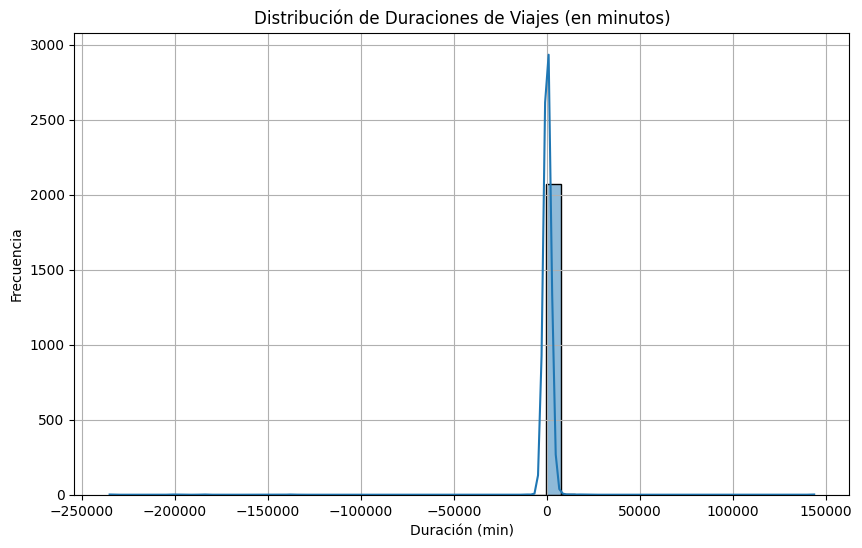

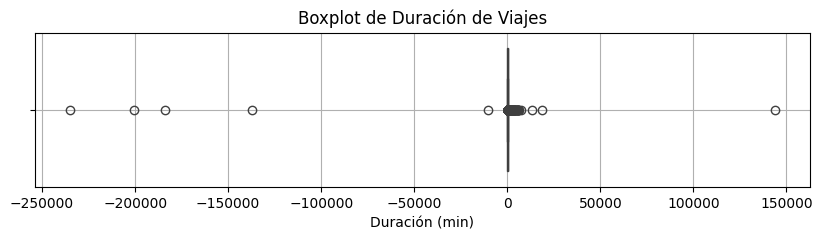

In [35]:
# Histograma general
plt.figure(figsize=(10, 6))
sns.histplot(trip_summary['duracion_minutos'], bins=50, kde=True)
plt.title("Distribución de Duraciones de Viajes (en minutos)")
plt.xlabel("Duración (min)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Boxplot para ver outliers
plt.figure(figsize=(10, 2))
sns.boxplot(x=trip_summary['duracion_minutos'])
plt.title("Boxplot de Duración de Viajes")
plt.xlabel("Duración (min)")
plt.grid(True)
plt.show()

In [38]:
# Aqui supongamos que el criterio experto dice miren no puede durar mas de 5 horas osea 300 minutos ni ser negativo y mayor a 1 hora 
# Criterio experto ampliado
trip_summary['outlier_experto'] = (
    (trip_summary['duracion_minutos'] > 300) |
    (trip_summary['duracion_minutos'] < 60) |
    (trip_summary['duracion_minutos'] < 0)
)

# Ademas agregemos un criterio estadistico basado en el rango intercuartico
Q1 = trip_summary['duracion_minutos'].quantile(0.25)
Q3 = trip_summary['duracion_minutos'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

trip_summary['outlier_iqr'] = (trip_summary['duracion_minutos'] < limite_inferior) | \
                              (trip_summary['duracion_minutos'] > limite_superior)

#Ahora marquemos el outlier final 
trip_summary['outlier_final'] = trip_summary['outlier_experto'] | trip_summary['outlier_iqr']

# 4. Mostrar resumen
print("🔎 Viajes marcados como outlier (criterio experto):", trip_summary['outlier_experto'].sum())
print("🔎 Viajes marcados como outlier (IQR):", trip_summary['outlier_iqr'].sum())
print("✅ Total viajes marcados como outlier (combinado):", trip_summary['outlier_final'].sum())


🔎 Viajes marcados como outlier (criterio experto): 576
🔎 Viajes marcados como outlier (IQR): 412
✅ Total viajes marcados como outlier (combinado): 576


In [44]:
trip_summary_final=trip_summary[trip_summary['outlier_final']==False]

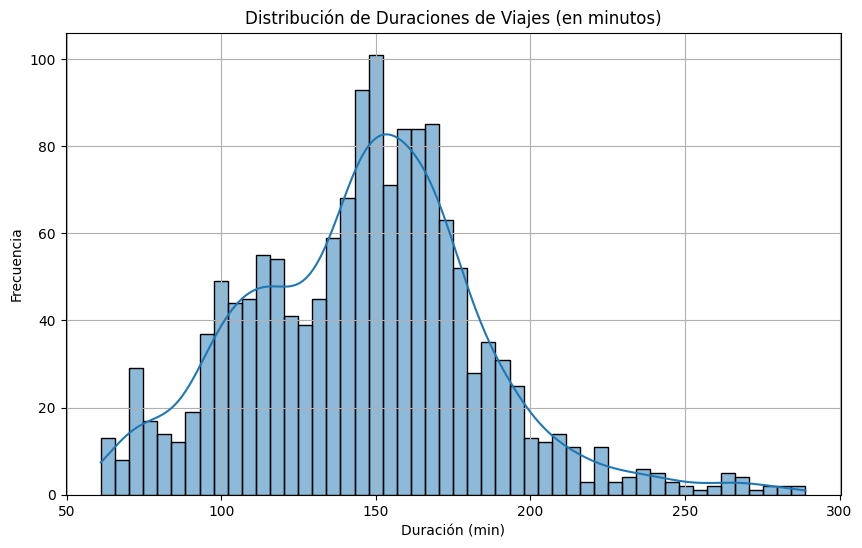

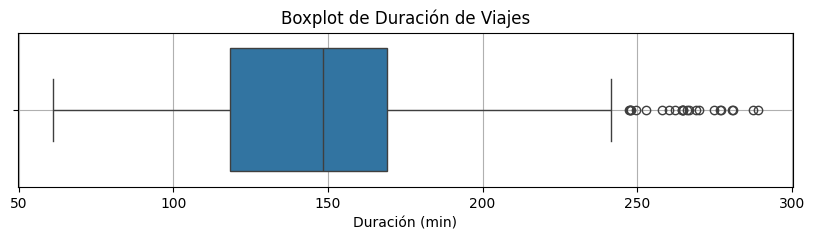

In [45]:
# Histograma general
plt.figure(figsize=(10, 6))
sns.histplot(trip_summary_final['duracion_minutos'], bins=50, kde=True)
plt.title("Distribución de Duraciones de Viajes (en minutos)")
plt.xlabel("Duración (min)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Boxplot para ver outliers
plt.figure(figsize=(10, 2))
sns.boxplot(x=trip_summary_final['duracion_minutos'])
plt.title("Boxplot de Duración de Viajes")
plt.xlabel("Duración (min)")
plt.grid(True)
plt.show()

In [46]:
trip_summary_final

,trip_id,VehicleID,origen,destino,inicio,fin,duracion_minutos,num_paradas,stop_duration_total_minutos,duracion_horas,stop_duration_horas,outlier_experto,outlier_iqr,outlier_final
1,2.0,BUS-KDVX32,viña del mar,pajaritos,2024-10-05 07:43:15,2024-10-05 09:24:31,101.266667,11,45.300000,1.687778,0.755000,False,False,False
2,3.0,BUS-KDVX32,pajaritos,viña del mar,2024-10-05 09:25:03,2024-10-05 13:19:17,234.233333,19,183.483333,3.903889,3.058056,False,False,False
3,4.0,BUS-KDVX32,san borja,viña del mar,2024-10-05 13:40:58,2024-10-05 16:22:28,161.500000,9,499.416667,2.691667,8.323611,False,False,False
4,5.0,BUS-KDVX32,viña del mar,san borja,2024-10-05 17:38:08,2024-10-05 18:40:39,62.516667,4,306.633333,1.041944,5.110556,False,False,False
5,6.0,BUS-KDVX32,san borja,viña del mar,2024-10-05 20:12:23,2024-10-05 22:52:09,159.766667,3,309.516667,2.662778,5.158611,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,2077.0,bus_5,viña del mar,san borja,2024-11-17 18:36:59,2024-11-17 21:34:25,177.433333,4,54.933333,2.957222,0.915556,False,False,False
2077,2078.0,bus_5,san borja,viña del mar,2024-11-17 21:49:05,2024-11-18 00:05:39,136.566667,5,10.283333,2.276111,0.171389,False,False,False
2078,2079.0,bus_5,viña del mar,san borja,2024-11-18 07:04:29,2024-11-18 09:22:46,138.283333,2,12.983333,2.304722,0.216389,False,False,False
2079,2080.0,bus_5,san borja,viña del mar,2024-11-18 09:42:28,2024-11-18 11:32:21,109.883333,3,23.816667,1.831389,0.396944,False,False,False


In [47]:
OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)
trip_summary_final.to_csv(OUTPUT_DIR / "viajes.csv", index=False)